## Import packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/NeRF/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from opt import get_opts
from config import Config
from model_utils import generate_rays, perform_volume_rendering
from render import pose_spherical

import gin
from pickletools import optimize

import numpy as np
import jax
from jax import numpy as jnp
from jax import jit, pmap, value_and_grad, lax, \
                local_device_count, \
                device_put_replicated, local_devices

from flax.jax_utils import unreplicate
from flax.training import train_state, common_utils
import optax

from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio

## Run on TPU if using Colab (*optional*)

In [4]:
import jax
import os

if 'TPU_NAME' in os.environ:
    import requests
    if 'TPU_DRIVER_MODE' not in globals():
        url = 'http:' + os.environ['TPU_NAME'].split(':')[1] + ':8475/requestversion/tpu_driver_nightly'
        resp = requests.post(url)
        TPU_DRIVER_MODE = 1
    from jax.config import config
    config.FLAGS.jax_xla_backend = "tpu_driver"
    config.FLAGS.jax_backend_target = os.environ['TPU_NAME']
    print("TPU DETECTED!")
    print('Registered TPU:', config.FLAGS.jax_backend_target)


# Detect if Google Colab Notebook has access to TPUs or not
elif "COLAB_TPU_ADDR" in os.environ:
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()


else:
    print('No TPU detected.')


DEVICE_COUNT = len(jax.local_devices())
TPU = DEVICE_COUNT>=1
print("DEVICE_COUNT: ", DEVICE_COUNT)

if TPU:
    print("8 cores of TPU ( Local devices in Jax ):")
    print('\n'.join(map(str,jax.local_devices())))


No TPU detected.
DEVICE_COUNT:  1
8 cores of TPU ( Local devices in Jax ):
gpu:0


## Load configurations and data

In [5]:
gin_config_path = "configs/default.gin"
#gin_config_path = "configs/hashnerf.gin"
gin.parse_config_file(gin_config_path)

config = Config()
print(config)

# load data
data = np.load("tiny_nerf_data.npz")
images = data["images"]
poses = data["poses"]
focal = float(data["focal"])

# split data into train and val
_, img_ht, img_wid, _ = images.shape
train_images, train_poses = images[:100], poses[:100]
val_image, val_pose = images[101], poses[101]

Config(near_bound=2.0, far_bound=6.0, num_sample_points=256, epsilon=10000000000.0, apply_positional_encoding=True, positional_encoding_dims=6, positional_encoding_dims_xyz=10, positional_encoding_dims_dir=4, positional_encoding_min_degree=1, positional_encoding_max_degree=10, bbox3D=DeviceArray([[-2.7, -2.7, -2.7],
             [ 2.2,  2.2,  2.2]], dtype=float32), num_dense_layers=2, dense_layer_width=256, num_dense_layers_dir=1, dense_layer_width_dir=128, skip_layer=0, batch_size=64, lr=0.0005, train_iteration=1000, plot_interval=100)


## Define routines for Training

In [6]:
from hash_encoding import HashEmbedder
from models import ToyNeRF, SimpleNeRF, VanillaNeRF, HashNeRF


def init_model(key, input_pts_shape):
    # create models
    model = ToyNeRF()
    #model = SimpleNeRF()
    #model = VanillaNeRF()
    #model = HashNeRF()

    # init model
    init_params = jit(model.init)({"params":key}, jnp.ones(input_pts_shape))

    return model, init_params["params"]


def train_step(state, batch, rng):
    """
    Training Step:
    state is comb of model state and optimizer state
    """
    inputs, targets = batch

    # compute loss in a stateless manner to save memory
    def loss_fn(params):
        ray_origins, ray_directions = inputs
        model_fn = lambda x: state.apply_fn({"params": params}, x)
        pred_rgbs, *_ = perform_volume_rendering(model_fn, ray_origins, ray_directions, rng)
        return jnp.mean( (pred_rgbs - targets)**2 )

    # get loss value and gradients    
    train_loss, gradients = value_and_grad(loss_fn)(state.params)

    # get averaged train loss
    train_loss = jnp.mean(train_loss)

    # compute all-reduce mean on gradients over the pmapped axis
    gradients = lax.pmean(gradients, axis_name="batch")

    # update model params & optimizer state
    new_state = state.apply_gradients(grads=gradients)

    # compute PSNR
    train_psnr = -10.0 * jnp.log(train_loss) / jnp.log(10.0)
    return train_loss, train_psnr, new_state

## Generate rays and init model

In [7]:
# create train and validation rays
train_rays = np.stack(list(map(lambda x: generate_rays(img_ht, img_wid, focal, x), train_poses)))
val_rays = generate_rays(img_ht, img_wid, focal, val_pose)

# number of devices
n_devices = local_device_count()
print("Using {} devices to compute".format(n_devices))

# rand number generation
key, rng = jax.random.split(jax.random.PRNGKey(0))

# init the model
model, params = init_model(key, (img_ht*img_wid, 3))

# optimizer
optimizer = optax.adam(learning_rate=config.lr)

# training state
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

# transfer arrays in the state to specified devices and form ShardedDeviceArrays
state = device_put_replicated(state, local_devices())

Using 1 devices to compute


## Define routines for validation

In [8]:
@jit
def validation_step(state):
    """
    Validation
    """
    model_fn = lambda x: state.apply_fn({"params": state.params}, x)
    ray_origins, ray_directions = val_rays

    pred_rgb, pred_depth, *_ = perform_volume_rendering(model_fn, ray_origins, ray_directions)

    val_loss = jnp.mean( (pred_rgb - val_image)**2 )
    val_psnr = -10.0 * jnp.log(val_loss) / jnp.log(10.0)
    return pred_rgb, pred_depth, val_psnr, val_loss

In [9]:
import logging
from tqdm import trange
from tqdm.contrib.logging import logging_redirect_tqdm

LOG = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [10]:
def train_and_evaluate(state, train_step_fn, validation_step_fn):
    train_loss_history, train_psnr_history = [], []
    val_loss_history, val_psnr_history = [], []

    with logging_redirect_tqdm():
        for iteration in tqdm(range(config.train_iteration)):
            # shard random number generators
            rng_index, rng_iter = jax.random.split(jax.random.fold_in(rng, iteration))
            sharded_rngs = common_utils.shard_prng_key(rng_iter)

            # create training batch 
            train_index = jax.random.randint(rng_index, (n_devices,), minval=0, maxval=len(train_rays))
            train_batch = train_rays[tuple(train_index), ...],\
                          train_images[tuple(train_index), ...]
            
            # perform training step
            train_loss, train_psnr, state = train_step_fn(state, train_batch, sharded_rngs)
            avg_train_loss = np.asarray(np.mean(train_loss))
            avg_train_psnr = np.asarray(np.mean(train_psnr))
            train_loss_history.append(avg_train_loss)
            train_psnr_history.append(avg_train_psnr)
            
            # perform validation step
            validation_state = unreplicate(state)
            rgb, depth, val_psnr, val_loss = validation_step_fn(validation_state)
            avg_val_loss = np.asarray(np.mean(val_loss))
            avg_val_psnr = np.asarray(np.mean(val_psnr))
            val_loss_history.append(avg_val_loss)
            val_psnr_history.append(avg_val_psnr)
            
            # logging
            LOG.info("@ iteration {}: Train loss:{}, Val loss:{}, Train psnr:{}, Val psnr: {}".format(iteration, avg_train_loss, avg_val_loss, avg_train_psnr, avg_val_psnr))

            # plot result at every plot interval
            if iteration % config.plot_interval == 0:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
                ax1.imshow(rgb)
                ax1.set_title("Predicted RGB at iteration: {}".format(iteration))
                ax1.axis('off')
                ax2.imshow(depth)
                ax2.set_title('Predicted RGB at iteration: {}'.format(iteration))
                ax2.axis('off')
                plt.show()

    print("Train loss @ iteration {}: {}".format(iteration, avg_train_loss))
    print("Train psnr @ iteration {}: {}".format(iteration, avg_train_psnr))
    print("Val loss @ iteration {}: {}".format(iteration, avg_val_loss))
    print("Val psnr @ iteration {}: {}".format(iteration, avg_val_psnr))
    
    inference_state = unreplicate(state)
    history = {
        'train_loss': train_loss_history,
        'train_psnr': train_psnr_history,
        'val_loss': val_loss_history,
        'val_psnr': val_psnr_history
    }
    return state, inference_state, history

## Start training

  0%|          | 0/1000 [00:00<?, ?it/s]

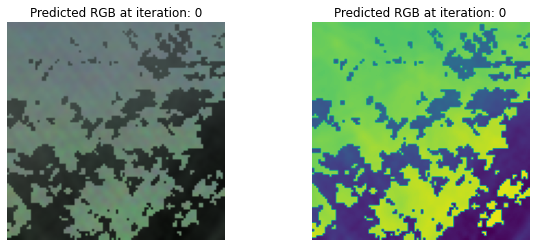

 10%|█         | 100/1000 [01:39<13:57,  1.07it/s]

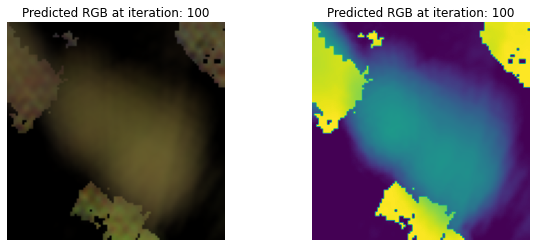

 20%|██        | 200/1000 [03:12<12:19,  1.08it/s]

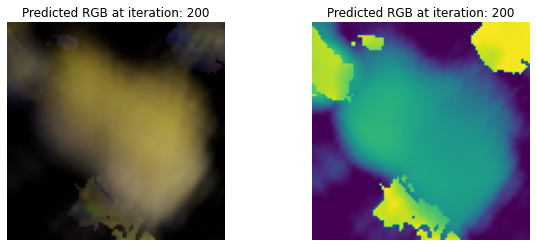

 30%|███       | 300/1000 [04:45<10:48,  1.08it/s]

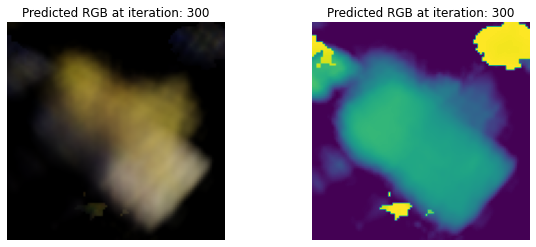

 40%|████      | 400/1000 [06:18<09:15,  1.08it/s]

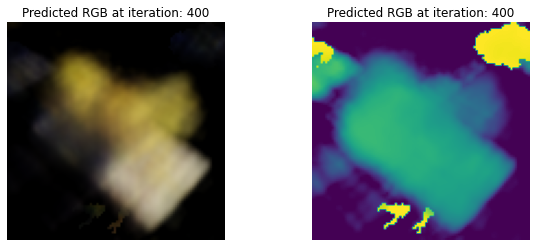

 50%|█████     | 500/1000 [07:50<07:42,  1.08it/s]

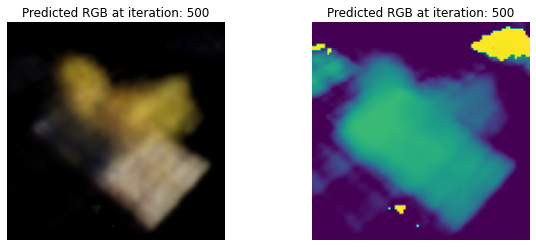

 60%|██████    | 600/1000 [09:23<06:10,  1.08it/s]

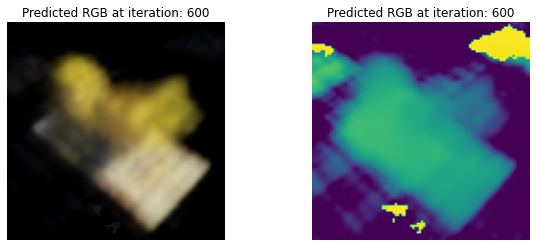

 70%|███████   | 700/1000 [10:55<04:37,  1.08it/s]

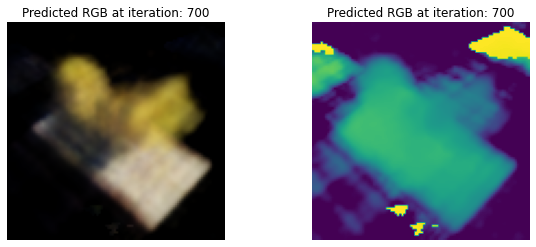

 80%|████████  | 800/1000 [12:28<03:04,  1.09it/s]

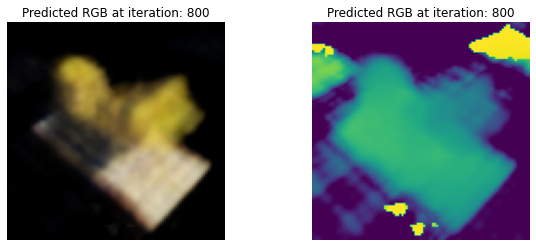

 90%|█████████ | 900/1000 [14:00<01:32,  1.08it/s]

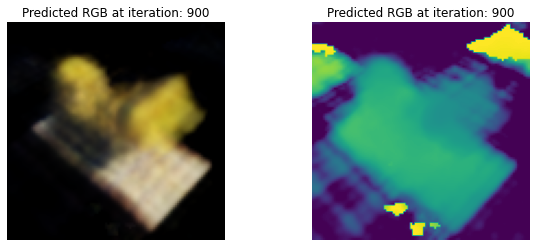

100%|██████████| 1000/1000 [15:33<00:00,  1.07it/s]

Train loss @ iteration 999: 0.011158127337694168
Train psnr @ iteration 999: 19.524085998535156
Val loss @ iteration 999: 0.010884840972721577
Val psnr @ iteration 999: 19.631778717041016


In [11]:

# perform training now
# Apply the transform jax.pmap on the train_step to parallelize it on XLA devices
# While vmap vectorizes a function by adding a batch dimension to every primitive operation 
# in the function, pmap replicates the function and executes each replica 
# on its own XLA device in parallel.
parallelized_train_step = pmap(train_step, axis_name="batch")
state, inference_state, history = train_and_evaluate(state, parallelized_train_step, validation_step)


## Render the scene

In [12]:
@jit
def get_renderings(rays):
    model_fn = lambda x: inference_state.apply_fn(
        {"params": inference_state.params}, x
    )

    ray_origins, ray_directions = rays
    rgb, depth, acc, disparity, opacities = perform_volume_rendering(
        model_fn, ray_origins, ray_directions
    )
    rgb = (255 * jnp.clip(rgb, 0, 1)).astype(jnp.uint8)
    return rgb, depth, acc, disparity, opacities


# Create a 360 degree video of the 3D scene
def get_frames():
    video_angle = jnp.linspace(0.0, 360.0, 120, endpoint=False)
    camera_to_world_transform = map(lambda th: pose_spherical(th, -30.0, 4.0), video_angle)
    rays = np.stack(list(map(
        lambda x: generate_rays(
            img_ht, img_wid, focal, x[:3, :4]
        ), camera_to_world_transform
    )))
    rgb_frames, depth_frames, acc_maps, disparity_maps, opacities = lax.map(get_renderings, rays)
    rgb_frames = np.asarray(rgb_frames)
    depth_frames = np.asarray(depth_frames)
    acc_maps = np.asarray(acc_maps * 255.)
    disparity_maps = np.asarray(disparity_maps * 255.)
    return rgb_frames, depth_frames, acc_maps, disparity_maps

In [13]:
# render the scene
rgb_frames, depth_frames, acc_maps, disparity_maps = get_frames()

## Export videos

In [14]:
# output videos
imageio.mimwrite("rgb_video.mp4", tuple(rgb_frames), fps=30, quality=7)
imageio.mimwrite("depth_video.mp4", tuple(depth_frames), fps=30, quality=7)
imageio.mimwrite("acc_video.mp4", tuple(acc_maps), fps=30, quality=7)
imageio.mimwrite("disparity_video.mp4", tuple(disparity_maps), fps=30, quality=7)